<a href="https://colab.research.google.com/github/2series/100_Days_of_ML_Code/blob/master/BTC_Price_Analysis_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [5]:
from google.colab import files
files.upload()

Saving bitcoin_ticker.csv to bitcoin_ticker.csv


In [0]:
df = pd.read_csv('bitcoin_ticker.csv')

In [43]:
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


In [44]:
df.dtypes

date_id          object
datetime_id      object
market           object
rpt_key          object
last            float64
diff_24h        float64
diff_per_24h    float64
bid             float64
ask             float64
low             float64
high            float64
volume          float64
created_at       object
updated_at       object
dtype: object

In [45]:
df.shape

(627190, 14)

#Feature  Extraction

In [46]:
df['rpt_key'].value_counts()

btc_usd       125438
eth_btc        62719
ltc_usd        62719
btc_eur        62719
btc_krw        62719
etc_krw        62719
btc_jpy        62719
eth_krw        62719
fx_btc_jpy     62719
Name: rpt_key, dtype: int64

In [0]:
df = df.loc[(df['rpt_key'] == 'btc_usd')]

In [48]:
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


# Convert datetime_id to data type and filter dates greater than 2017-06-28 00:00:00

In [0]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [0]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

In [51]:
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
77762,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.0,2473.19,20719.583592
77763,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.0,2780.62,2265.557866
77764,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.0,2473.19,20732.082581
77765,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.0,2780.62,2262.618866
77766,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.0,2473.19,20665.357191


# We require only the 'last value' column, thus subset that and convert it to numpy array

In [0]:
df = df[['last']]

In [0]:
dataset = df.values
dataset = dataset.astype('float32')

In [57]:
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]], dtype=float32)

Neural networks are sensitive to input data, especiallly when using activation functions. Hence, we rescale our data to the range of 0-to-1, using MinMaxScaler



In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [59]:
dataset

array([[0.1997695 ],
       [0.49828053],
       [0.18666792],
       ...,
       [0.29587936],
       [0.15456724],
       [0.29587936]], dtype=float32)

# Splitting of data

In [138]:
train = int(len(dataset) * 0.69)
test = len(dataset) - train
train, test = dataset[0:train, :], dataset[train:len(dataset), :]
print(len(train), len(test))

32896 14780


Now let us define the function called create_dataset, which take two inputs,

*   Dataset - numpy array that we want to convert into a dataset
*   Look_back - number of previous time steps to use as input variables to predict the next time period

In [0]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [0]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [141]:
trainX

array([[0.1997695 , 0.49828053, 0.18666792, ..., 0.4975314 , 0.19973087,
        0.4860053 ],
       [0.49828053, 0.18666792, 0.4855442 , ..., 0.19973087, 0.4860053 ,
        0.18442059],
       [0.18666792, 0.4855442 , 0.18251848, ..., 0.4860053 , 0.18442059,
        0.48598576],
       ...,
       [0.59613895, 0.8365383 , 0.6023631 , ..., 0.81961393, 0.6017289 ,
        0.81961393],
       [0.8365383 , 0.6023631 , 0.83350277, ..., 0.6017289 , 0.81961393,
        0.5976372 ],
       [0.6023631 , 0.83350277, 0.60199785, ..., 0.81961393, 0.5976372 ,
        0.81961393]], dtype=float32)

In [142]:
trainY

array([0.18442059, 0.48598576, 0.19208527, ..., 0.5976372 , 0.81961393,
       0.5976372 ], dtype=float32)

In [0]:
# Reshape input to be [samples, time steps, features

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Building our Model: You're always trying to minimize the error (RMSE )when building the model

In [144]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0596
Epoch 2/100
 - 0s - loss: 0.0026
Epoch 3/100
 - 0s - loss: 0.0010
Epoch 4/100
 - 0s - loss: 3.6556e-04
Epoch 5/100
 - 0s - loss: 2.1128e-04
Epoch 6/100
 - 0s - loss: 1.6644e-04
Epoch 7/100
 - 0s - loss: 1.4248e-04
Epoch 8/100
 - 0s - loss: 1.2903e-04
Epoch 9/100
 - 0s - loss: 1.2185e-04
Epoch 10/100
 - 0s - loss: 1.1838e-04
Epoch 11/100
 - 0s - loss: 1.1684e-04
Epoch 12/100
 - 0s - loss: 1.1597e-04
Epoch 13/100
 - 0s - loss: 1.1552e-04
Epoch 14/100
 - 0s - loss: 1.1525e-04
Epoch 15/100
 - 0s - loss: 1.1499e-04
Epoch 16/100
 - 0s - loss: 1.1487e-04
Epoch 17/100
 - 0s - loss: 1.1456e-04
Epoch 18/100
 - 0s - loss: 1.1405e-04
Epoch 19/100
 - 0s - loss: 1.1381e-04
Epoch 20/100
 - 0s - loss: 1.1352e-04
Epoch 21/100
 - 0s - loss: 1.1324e-04
Epoch 22/100
 - 0s - loss: 1.1286e-04
Epoch 23/100
 - 0s - loss: 1.1257e-04
Epoch 24/100
 - 0s - loss: 1.1221e-04
Epoch 25/100
 - 0s - loss: 1.1179e-04
Epoch 26/100
 - 0s - loss: 1.1160e-04
Epoch 27/100
 - 0s - loss: 1.1128

In [0]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

We invert predictions before calculating error to, so reports can be generated in same units as our original df

In [0]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [147]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.84 RMSE
Test Score: 6.49 RMSE


# **RMSE of test > RMSE of train, means OVER FITTING OF THE DATA.**

# The RMSE in our training and  testing sets should be very similar if I've built a good model. 

# The RMSE for the test set is higher than that of the training set, meaning I've created a model that tests well in sample, but has little predictive value when tested out of sample

In [0]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

In [0]:
# Shift test predictions for plotting

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

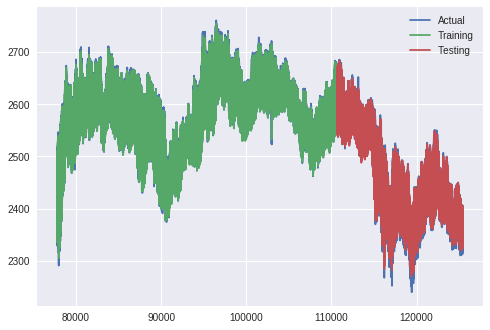

In [150]:
plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()